In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append(r'D:\github\ripple_heterogeneity\python')
import replay_rank_order
import functions,loading
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import importlib
import glob
import os
import pickle
import replay_fig
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
import random

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


## Load all single cell data to inspect pyr distance

In [22]:
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
cell_metrics = loading.load_all_cell_metrics(df.basepath)

In [23]:
keep_idx = (cell_metrics.putativeCellType.str.contains('Pyramidal') &
            cell_metrics.brainRegion.str.contains('CA1') &
            (cell_metrics.bad_unit == False))
cell_metrics = cell_metrics[keep_idx]

<AxesSubplot:xlabel='deepSuperficialDistance', ylabel='burstIndex_Mizuseki2012'>

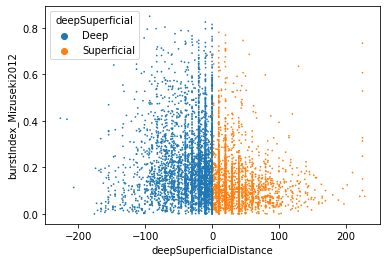

In [24]:
sns.scatterplot(data=cell_metrics, x="deepSuperficialDistance", y="burstIndex_Mizuseki2012",
                hue="deepSuperficial",
                linewidth=0,s=3)

In [25]:
cell_metrics[(cell_metrics.deepSuperficial == "Deep") & (cell_metrics.deepSuperficialDistance >0) ].basepath.value_counts()[0:20]
cell_metrics[(cell_metrics.deepSuperficial == "Deep") & (cell_metrics.deepSuperficialDistance >0) ].basepath.unique()


array([], dtype=object)

In [26]:
cell_metrics[(cell_metrics.brainRegion == 'CA1') & (cell_metrics.bad_unit == False)].basepath.value_counts()[0:20]

Z:\Data\AYAold\AB3\AB3_38_41               82
Z:\Data\AYAold\AB3\AB3_50_51               79
Z:\Data\AYAold\AB3\AB3_58_59               78
Z:\Data\GirardeauG\Rat11\Rat11-20150331    74
Z:\Data\Kenji\ec016.577_590                72
Z:\Data\AYAold\AB3\AB3_47_49               71
Z:\Data\ORproject\OR15\day3                69
Z:\Data\ORproject\OR15\day4                67
Z:\Data\Kenji\ec014.271_287                67
Z:\Data\Kenji\ec014.207_234                66
Z:\Data\ORproject\OR15\day2                66
Z:\Data\Kenji\ec014.192_204                63
Z:\Data\GirardeauG\Rat11\Rat11-20150327    62
Z:\Data\Kenji\ec014.459_480                60
Z:\Data\AYAold\AB3\AB3_55_57               59
Z:\Data\AYAold\AYA9\day12                  58
Z:\Data\AYAold\AB1\day1                    57
Z:\Data\AYAold\AYA9\day20                  56
Z:\Data\Kenji\ec016.491_508                56
Z:\Data\AYAold\AYA9\day15                  55
Name: basepath, dtype: int64

### An ongoing attempt is being made to classify sub layers

<AxesSubplot:xlabel='deepSuperficialDistance', ylabel='brainRegion'>

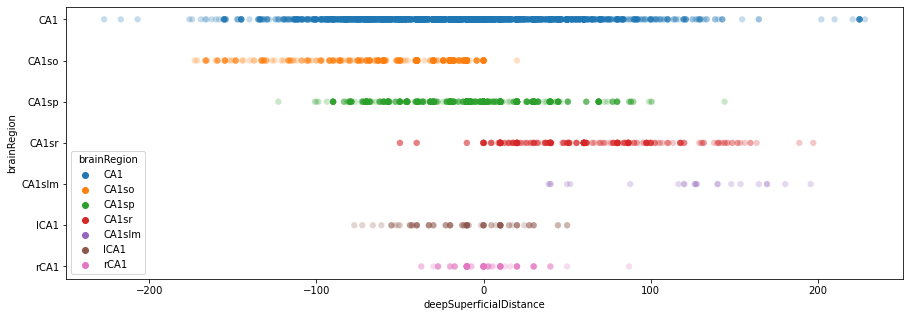

In [27]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=cell_metrics, x="deepSuperficialDistance", y="brainRegion",
                hue="brainRegion",
                linewidth=0,s=40,alpha=.25)

In [28]:
cell_metrics[cell_metrics.deepSuperficialDistance < 100][['UID','basepath']].basepath.value_counts()


Z:\Data\GrosmarkAD\Achilles\Achilles_10252013    235
Z:\Data\ORproject\OR15\day10                     139
Z:\Data\ORproject\OR22\day5                      102
Z:\Data\GrosmarkAD\Achilles\Achilles_11012013     94
Z:\Data\Kenji\i01_maze05_MS.001_003               90
                                                ... 
Z:\Data\GirardeauG\Rat11\Rat11-20150323            2
Z:\Data\Kenji\ec014.120_130                        2
Z:\Data\Kenji\2006-4-18                            1
Z:\Data\Kenji\ec013.853_866                        1
Z:\Data\Kenji\km01.041_053                         1
Name: basepath, Length: 217, dtype: int64

In [29]:
cell_metrics[np.isnan(cell_metrics.deepSuperficialDistance)][['UID','basepath']]
cell_metrics[np.isnan(cell_metrics.deepSuperficialDistance)].basepath.value_counts()

Series([], Name: basepath, dtype: int64)

In [303]:
# def find_units_on_shanks_w_polarity_reversal(df):
#     for basepath in df.basepath.unique():
#         cell_metrics = df[df.basepath == basepath]
#         (
#             channel_df,
#             ripple_average,
#             ripple_time_axis,
#         ) = loading.load_deepSuperficialfromRipple(
#             basepath, bypass_mismatch_exception=True
#         )
#         channel_df.shank = channel_df.shank + 1
#         for shank in channel_df.shank.unique():
#             if channel_df[channel_df.shank == shank].channelClass.unique().shape[0] == 2:
#                 channel_df.loc[channel_df.shank == shank, "polarity_reversal"] = True
#             else:
#                 channel_df.loc[channel_df.shank == shank, "polarity_reversal"] = False

#         bool_array = np.in1d(
#             cell_metrics.shankID.values,
#             channel_df[channel_df.polarity_reversal].shank.unique(),
#         )
#         cell_metrics.loc[bool_array, "polarity_reversal"] = True
#         cell_metrics.loc[~bool_array, "polarity_reversal"] = False

#         df.loc[df.basepath == basepath, "polarity_reversal"] = cell_metrics.polarity_reversal
#     return df


# cell_metrics = find_units_on_shanks_w_polarity_reversal(cell_metrics)


C:\Users\Cornell\AppData\Local\Temp/ipykernel_12348/1317948301.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Classify channels by avg ripple trace

### Gather data

In [364]:
# basepath = r'Z:\Data\AYAold\AB1\day1'
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")
ripple_average = []
ripple_df = pd.DataFrame()

for basepath in df.basepath.unique():
    channel_df, ripple_avg, ripple_time_axis = loading.load_deepSuperficialfromRipple(
        basepath, bypass_mismatch_exception=False
    )
    ripple_df = pd.concat([ripple_df, channel_df], ignore_index=True)
    ripple_average.append(ripple_avg)
ripple_average = np.vstack(ripple_average)
# only keep with ca1 shank
ripple_average = ripple_average[(ripple_df.ca1_shank == True), :]
ripple_df = ripple_df[(ripple_df.ca1_shank == True)]


### show ripple avg of shanks with reversal

<AxesSubplot:>

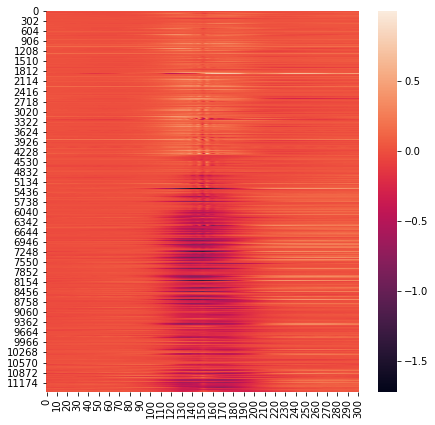

In [366]:
plt.figure(figsize=(7,7))
idx = np.argsort(ripple_df[(ripple_df.polarity_reversal == True)].channelDistance)
sns.heatmap(ripple_average[(ripple_df.polarity_reversal == True),:][idx])

# plt.figure(figsize=(7,7))
# idx = np.argsort(ripple_df[(ripple_df.polarity_reversal == False) & (ripple_df.ca1_shank == True)].channelDistance)
# sns.heatmap(ripple_average[(ripple_df.polarity_reversal == False) & (ripple_df.ca1_shank == True),:][idx])

### Reduce dims with PCA

In [367]:
from sklearn.decomposition import PCA
# X = ripple_average[np.any(~np.isnan(ripple_average),axis=1)]
X = ripple_average[(ripple_df.ca1_shank == True)]

pca = PCA(n_components=10)
pca.fit(X)
X_ = pca.transform(X)

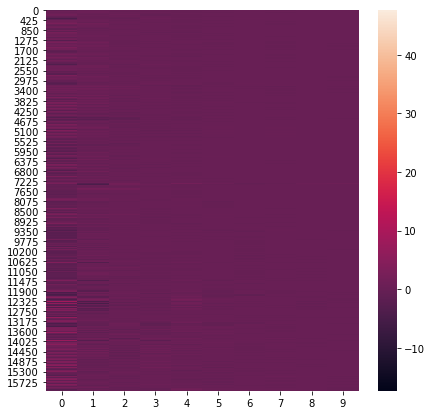

In [369]:

plt.figure(figsize=(7,7))
sns.heatmap(X_)

ripple_df['pc1'] = X_[:,0]
ripple_df['pc2'] = X_[:,1]
ripple_df['pc3'] = X_[:,2]
ripple_df['pc4'] = X_[:,3]
ripple_df['pc5'] = X_[:,4]
ripple_df['pc6'] = X_[:,5]
ripple_df['pc7'] = X_[:,6]
ripple_df['pc8'] = X_[:,7]
ripple_df['pc9'] = X_[:,8]
ripple_df['pc10'] = X_[:,9]


### show avg ripples above and below pyr layer

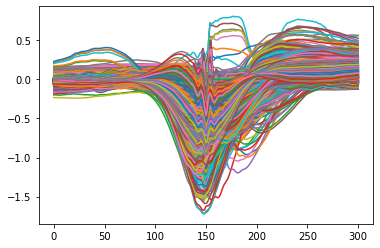

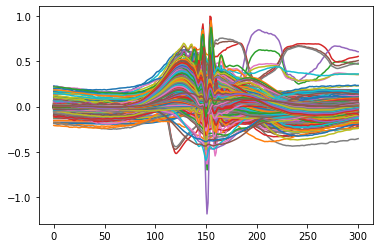

In [312]:
plt.plot(
    ripple_average[
        (ripple_df.polarity_reversal == True)
        & (ripple_df.ca1_shank == True)
        & (ripple_df.channelDistance > 0),
        :,
    ].T
)
plt.show()

plt.plot(
    ripple_average[
        (ripple_df.polarity_reversal == True)
        & (ripple_df.ca1_shank == True)
        & (ripple_df.channelDistance < 0),
        :,
    ].T
)
plt.show()

### explore relation between features

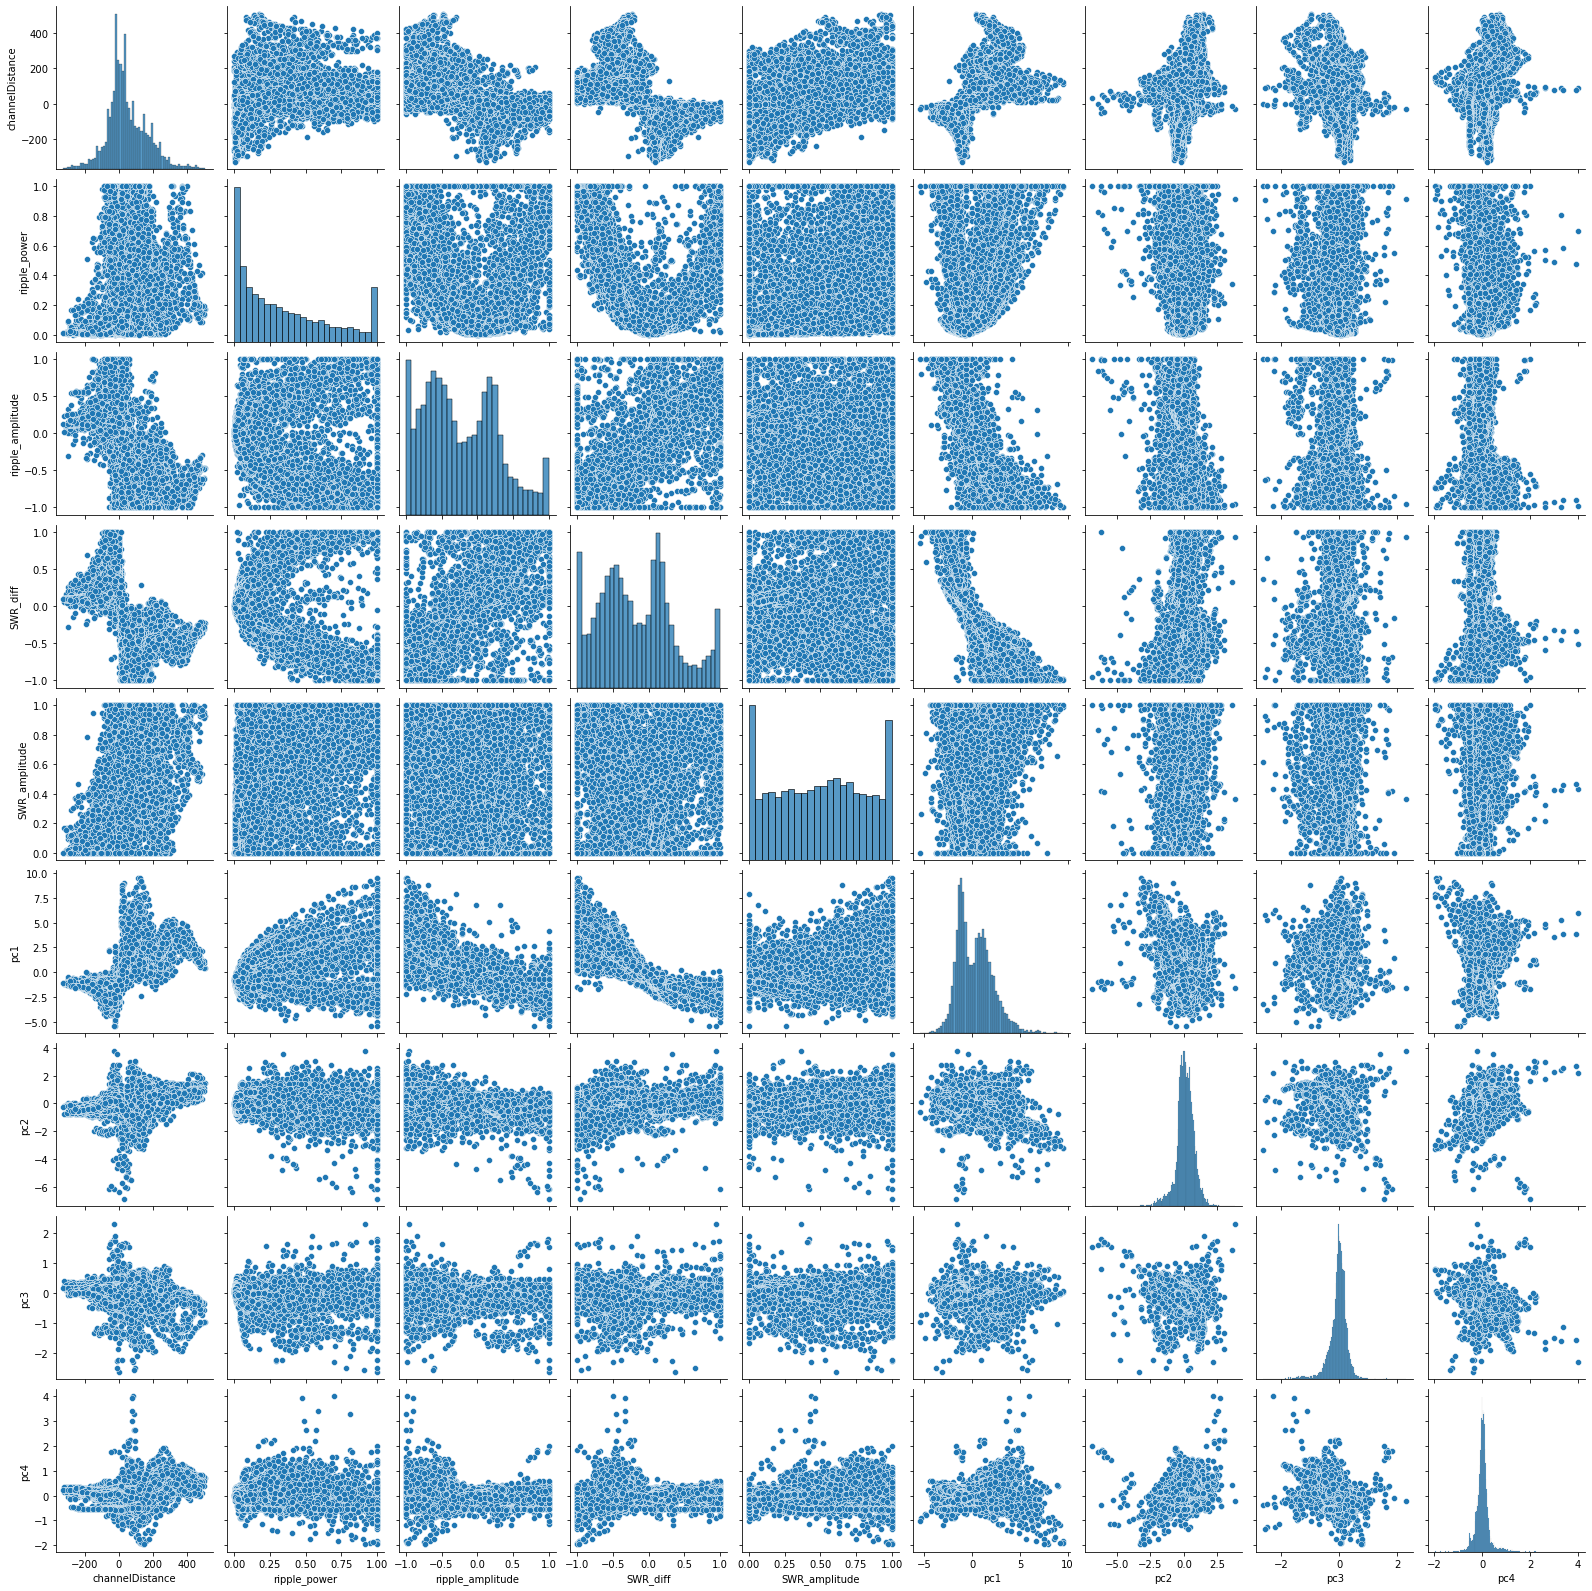

In [120]:
sns.pairplot(
    ripple_df[(ripple_df.polarity_reversal == True)][
        [
            "channelDistance",
            "ripple_power",
            "ripple_amplitude",
            "SWR_diff",
            "SWR_amplitude",
            "pc1",
            "pc2",
            "pc3",
            "pc4",
        ]
    ]
)

### Use regressor to make model of channel distance from pyr layer

Here, I am using shanks with polarity reversal in order to predict from shanks without a reversal 

In [370]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score

ripple_df_ = pd.concat(
    [ripple_df, pd.get_dummies(ripple_df.channelClass, prefix="class")], axis=1
)
vars = [
    "ripple_power",
    "ripple_amplitude",
    "SWR_diff",
    "SWR_amplitude",
    "pc1",
    "pc2",
    "pc3",
    "pc4",
    "pc5",
    "pc6",
    "pc7",
    "pc8",
    "pc9",
    "pc10",
    "shank",
]
X = ripple_df_[vars].values


y = ripple_df_.channelDistance.values

X = X[(ripple_df_.polarity_reversal == True), :]
y = y[(ripple_df_.polarity_reversal == True)]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg = ExtraTreesRegressor(n_estimators=200, random_state=0)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

df_ = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})

print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

scores = cross_val_score(reg, X_test, y_test, cv=5)
print("cross val score test set: ", scores.mean())

scores = cross_val_score(reg, X_train, y_train, cv=5)
print("cross val score train set: ", scores.mean())


Mean Absolute Error: 16.534614293959272
Mean Squared Error: 778.0356143222454
Root Mean Squared Error: 27.893289772313437
cross val score test set:  0.886019449702807
cross val score train set:  0.9457197388219771


### inspect important features

array(['SWR_diff', 'ripple_amplitude', 'pc1', 'shank', 'SWR_amplitude',
       'pc4', 'pc2', 'pc6', 'pc10', 'pc3', 'pc5', 'pc9', 'ripple_power',
       'pc8', 'pc7'], dtype='<U16')

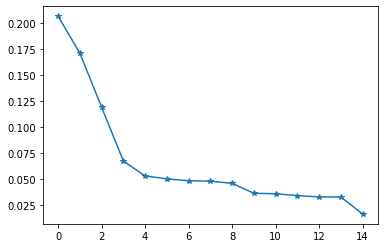

In [371]:
plt.plot(reg.feature_importances_[np.argsort(-reg.feature_importances_,)],marker="*")
np.array(vars)[np.argsort(-reg.feature_importances_,)]

### Inspect real and predicted distance for reversal and non-reversal shanks

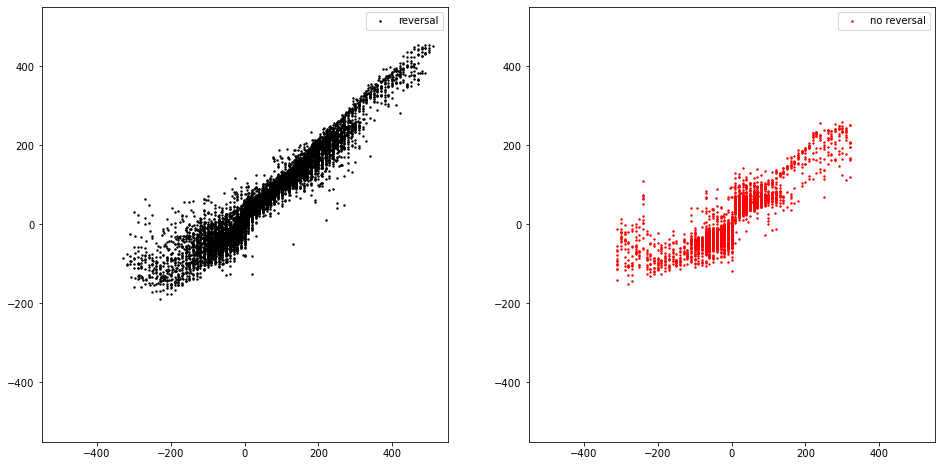

In [372]:
X = ripple_df_[
    [
        "ripple_power",
        "ripple_amplitude",
        "SWR_diff",
        "SWR_amplitude",
        "pc1",
        "pc2",
        "pc3",
        "pc4",
        "pc5",
        "pc6",
        "pc7",
        "pc8",
        "pc9",
        "pc10",
        "shank",
    ]
].values
y = ripple_df_.channelDistance.values

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
# X = sm.add_constant(X)

y_pred = reg.predict(X)

fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].scatter(y[(ripple_df_.polarity_reversal == True)],y_pred[(ripple_df_.polarity_reversal == True)],color='k',s=2,label="reversal")
ax[1].scatter(y[(ripple_df_.polarity_reversal == False)],y_pred[(ripple_df_.polarity_reversal == False)],color='r',s=2,label="no reversal")
ax[0].set_xlim([-550,550])
ax[0].set_ylim([-550,550])
ax[1].set_xlim([-550,550])
ax[1].set_ylim([-550,550])
ax[0].legend()
ax[1].legend()

### add predicted to dataframe

In [373]:
ripple_df_['channelDistance_pred'] = y_pred

### save results for re-integration with mat files

In [374]:
ripple_df_.to_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\deep_sup_dist_estimation.csv')

## Example figures

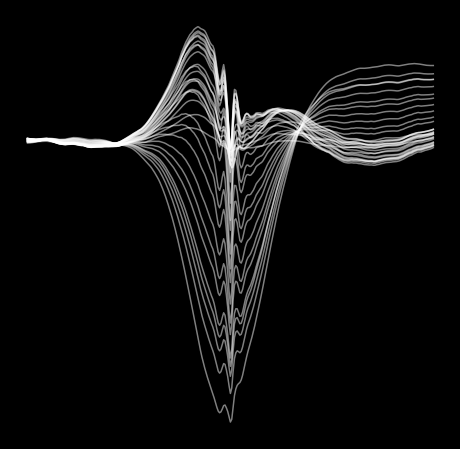

In [280]:
plt.style.use('dark_background')
basepath = "Z:\\Data\\HMC1\\day8"
channel_df, ripple_average, ripple_time_axis = loading.load_deepSuperficialfromRipple(
    basepath, bypass_mismatch_exception=False
)
plt.figure(figsize=(8,8))
plt.plot(ripple_average[8],color='w',alpha=.5)
plt.axis('off')
plt.savefig(r'C:\Users\Cornell\Downloads\ripple.pdf',dpi=300,bbox_inches='tight')
plt.savefig(r'C:\Users\Cornell\Downloads\ripple.svg',dpi=300,bbox_inches='tight')
plt.savefig(r'C:\Users\Cornell\Downloads\ripple.png',dpi=300,bbox_inches='tight')
plt.savefig(r'C:\Users\Cornell\Downloads\ripple.jpeg',dpi=600,bbox_inches='tight')


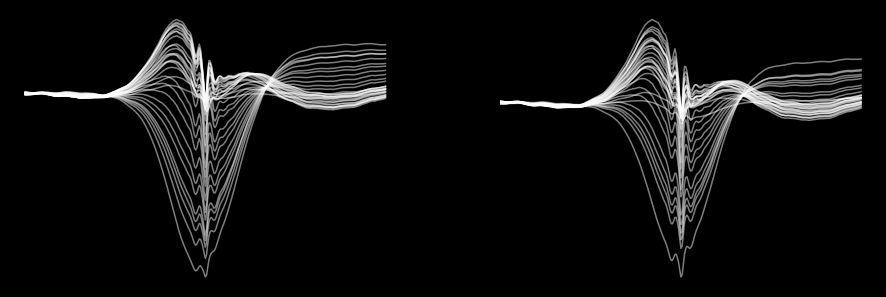

In [294]:
channel_df, ripple_average, ripple_time_axis = loading.load_deepSuperficialfromRipple(
    basepath, bypass_mismatch_exception=False
)
# plt.figure(figsize=(15.625,5.208333333333333))
# plt.plot(ripple_average[8],color='w',alpha=.5)
# plt.axis('off')

fig,ax = plt.subplots(1,2,figsize=(15.625,5.208333333333333))
[9,10,11,12]
for i,rip in enumerate(ripple_average[8:10]):
    offset = channel_df[channel_df.shank == i].channelDistance.T
    ax[i].plot(ripple_time_axis,rip,alpha=.5,color='w')
    ax[i].axis('off')
    ax[i].axis('tight')
plt.show()

## Explore deep / mid / sup

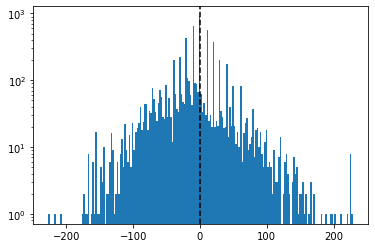

In [40]:
plt.hist(cell_metrics.deepSuperficialDistance,200)
plt.yscale('log')
plt.axvline(0,color='k',linestyle='--')
plt.show()

In [30]:
# np.arange(-210,220,20)
deep = -10
middle = [-10,10]
sup = 10

cell_metrics.loc[cell_metrics.deepSuperficialDistance  < deep, "ca1_layer"] = "deep"
cell_metrics.loc[(cell_metrics.deepSuperficialDistance  > middle[0]) & (cell_metrics.deepSuperficialDistance  < middle[1]), "ca1_layer"] = "middle"
cell_metrics.loc[cell_metrics.deepSuperficialDistance  > sup, "ca1_layer"] = "sup"


In [ ]:
print(cell_metrics.polarity_reversal.value_counts())
print(cell_metrics[cell_metrics.polarity_reversal].ca1_layer.value_counts())
# cell_metrics.polarity_reversal.shape

<AxesSubplot:xlabel='deepSuperficialDistance', ylabel='Density'>

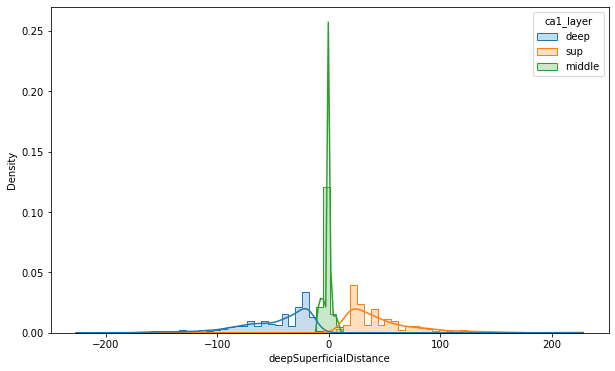

In [32]:
plt.figure(figsize=(10,6))
# sns.scatterplot(data=cell_metrics, x="deepSuperficialDistance", y="ca1_layer",
#                 hue="ca1_layer",
#                 linewidth=0,s=40,alpha=.25)

sns.histplot(
    data=cell_metrics, x="deepSuperficialDistance", hue="ca1_layer", element="step",
    stat="density", common_norm=False, kde=True
)

<AxesSubplot:xlabel='burstIndex_NREMstate', ylabel='Proportion'>

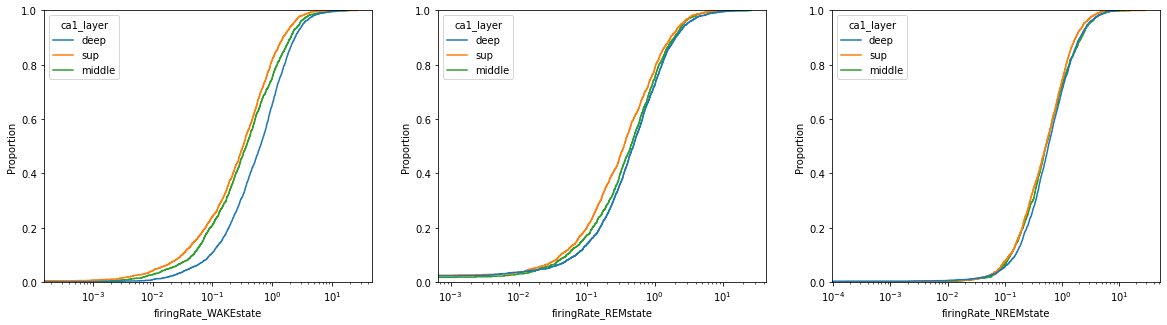

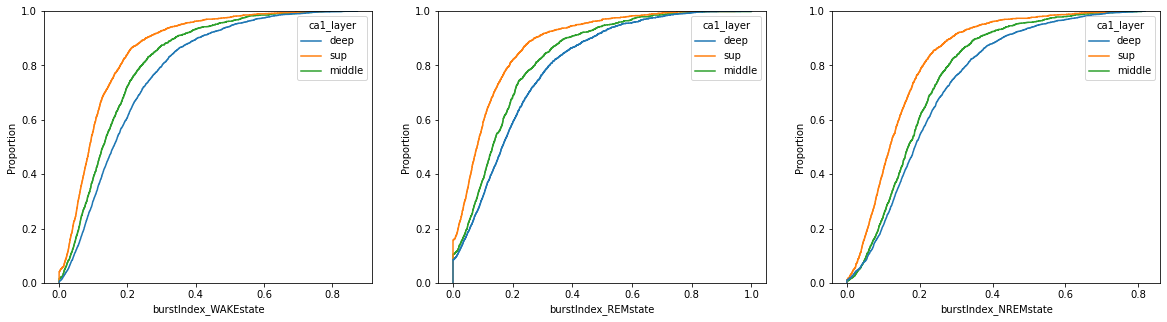

In [33]:
fig,ax = plt.subplots(1,3,figsize=(20, 5))
sns.ecdfplot(data=cell_metrics,
    x="firingRate_WAKEstate",
    hue="ca1_layer",
    ax=ax[0])
ax[0].set_xscale("log")

sns.ecdfplot(data=cell_metrics,
    x="firingRate_REMstate",
    hue="ca1_layer",
    ax=ax[1])
ax[1].set_xscale("log")

sns.ecdfplot(data=cell_metrics,
    x="firingRate_NREMstate",
    hue="ca1_layer",
    ax=ax[2])
ax[2].set_xscale("log")

fig,ax = plt.subplots(1,3,figsize=(20, 5))
sns.ecdfplot(data=cell_metrics,
    x="burstIndex_WAKEstate",
    hue="ca1_layer",
    ax=ax[0])
# ax[0].set_xscale("log")

sns.ecdfplot(data=cell_metrics,
    x="burstIndex_REMstate",
    hue="ca1_layer",
    ax=ax[1])
# ax[1].set_xscale("log")

sns.ecdfplot(data=cell_metrics,
    x="burstIndex_NREMstate",
    hue="ca1_layer",
    ax=ax[2])
# ax[2].set_xscale("log")

<AxesSubplot:xlabel='deepSuperficialDistance', ylabel='Count'>

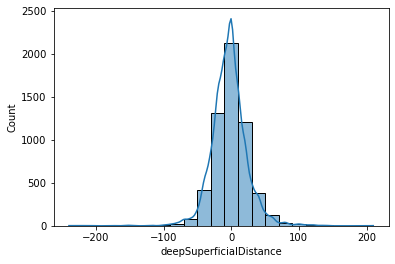

In [198]:

bins = np.arange(-210,220,20)
sns.histplot(data=cell_metrics[(cell_metrics.polarity_reversal == True)], x="deepSuperficialDistance", kde=True,bins=bins)

<AxesSubplot:xlabel='deepSuperficialDistance', ylabel='Density'>

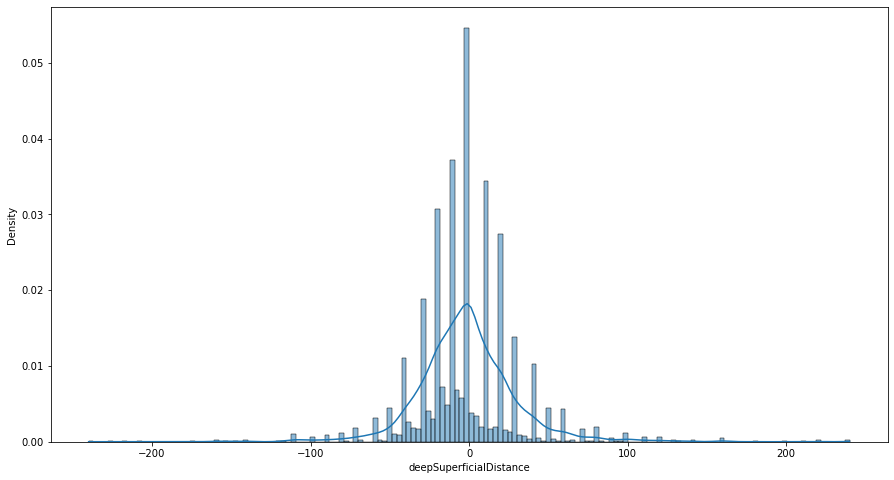

In [180]:
# plt.hist(cell_metrics.deepSuperficialDistance,150)
# plt.show()
# hue="brainRegion"
# [(cell_metrics.polarity_reversal == True)]
plt.figure(figsize=(15,8))
sns.histplot(data=cell_metrics, x="deepSuperficialDistance",stat="density", common_norm=False, kde=True)

## Testing below

In [172]:
# cell_metrics[['basepath','deepSuperficialDistance']][:30]

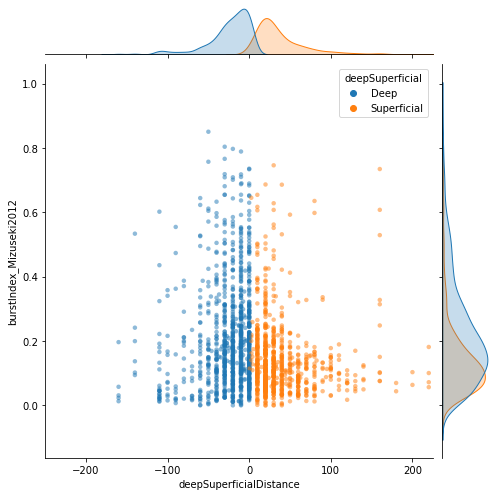

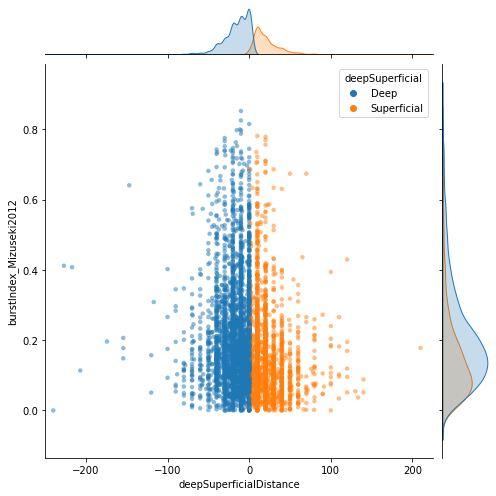

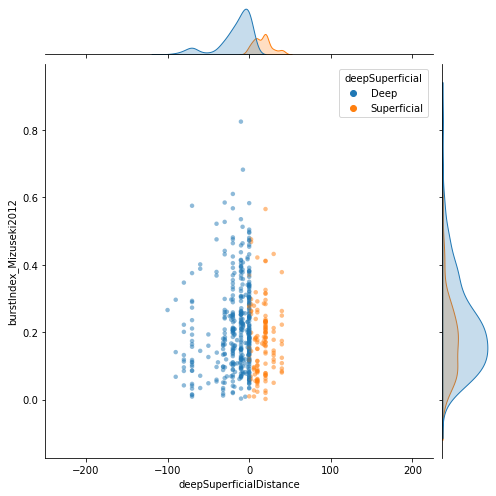

In [161]:
# plt.figure(figsize=(15,5))
# sns.scatterplot(
#     data=cell_metrics[cell_metrics.polarity_reversal == True],
#     x="deepSuperficialDistance",
#     y="brainRegion",
#     hue="brainRegion",
#     linewidth=0,
#     s=20,
#     alpha=.5
# )
sns.jointplot(data=cell_metrics[cell_metrics.polarity_reversal == False],
    x="deepSuperficialDistance",
    y="burstIndex_Mizuseki2012",
    hue="deepSuperficial",
    linewidth=0,
    s=20,
    alpha=.5,
    height=7, 
    ratio=7,xlim=[-250,225])

sns.jointplot(data=cell_metrics[cell_metrics.polarity_reversal == True],
    x="deepSuperficialDistance",
    y="burstIndex_Mizuseki2012",
    hue="deepSuperficial",
    linewidth=0,
    s=20,
    alpha=.5,
    height=7, 
    ratio=7,xlim=[-250,225])

sns.jointplot(data=cell_metrics[(cell_metrics.polarity_reversal == True) & (cell_metrics.brainRegion == "CA1sp")],
    x="deepSuperficialDistance",
    y="burstIndex_Mizuseki2012",
    hue="deepSuperficial",
    linewidth=0,
    s=20,
    alpha=.5,
    height=7, 
    ratio=7,xlim=[-250,225])


In [ ]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")
avg_rip = []
channel_df_all = pd.DataFrame()
for basepath in df.basepath:
    (
        channel_df,
        ripple_average,
        ripple_time_axis,
    ) = loading.load_deepSuperficialfromRipple(
        basepath, bypass_mismatch_exception=True
    )
    avg_rip.append(np.hstack(ripple_average).T)
    channel_df["basepath"] = basepath
    channel_df_all = pd.concat([channel_df_all, channel_df], ignore_index=True)


In [176]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

for basepath in df.basepath:
    try:
        brainRegions = loading.load_brain_regions(basepath)
    except:
        print(basepath)

In [179]:
brainRegions['PFC']

{'channels': array([  1,  14,  19,  32,  15,  18,   2,  16,  17,  13,  20,   4,  12,
         21,   5,  11,  22,   6,  10,  23,  31,   9,  24,  30,   8,  25,
         29,   7,  26,  28,  27,   3,  33,  46,  51,  64,  47,  50,  34,
         48,  49,  35,  45,  52,  36,  44,  53,  37,  43,  54,  38,  42,
         55,  63,  41,  56,  62,  40,  57,  61,  39,  58,  60,  59,  65,
         78,  83,  96,  79,  82,  66,  80,  81,  67,  77,  84,  68,  76,
         85,  69,  75,  86,  70,  74,  87,  95,  73,  88,  94,  72,  89,
         93,  71,  90,  92,  91,  97, 110, 115, 128, 111, 114,  98, 112,
        113,  99, 109, 116, 100, 108, 117, 101, 107, 118, 102, 106, 119,
        127, 105, 120, 126, 104, 121, 125, 103, 122, 124, 123], dtype=uint8),
 'electrodeGroups': array([1, 2, 3, 4], dtype=uint8)}

In [180]:
brainRegions['CA1']['channels']

array([270, 275, 288, 271, 274, 258, 272, 273, 269, 276, 260, 268, 277,
       261, 267, 278, 262, 266, 279, 287, 265, 280, 286, 264, 281, 285,
       263, 282, 284, 283, 259, 302, 307, 320, 303, 306, 290, 304, 305,
       291, 301, 308, 292, 300, 309, 293, 299, 310, 294, 298, 311, 319,
       297, 312, 318, 296, 313, 317, 295, 314, 316, 315, 334, 339, 352,
       335, 338, 322, 336, 337, 323, 333, 340, 324, 332, 341, 325, 331,
       342, 326, 330, 343, 351, 329, 344, 350, 328, 345, 349, 327, 346,
       348, 347, 366, 371, 384, 367, 370, 354, 368, 369, 355, 365, 372,
       356, 364, 373, 357, 363, 374, 358, 362, 375, 383, 361, 376, 382,
       360, 377, 381, 359, 378, 380, 379], dtype=uint16)

In [25]:
avg_rip = np.vstack(avg_rip)

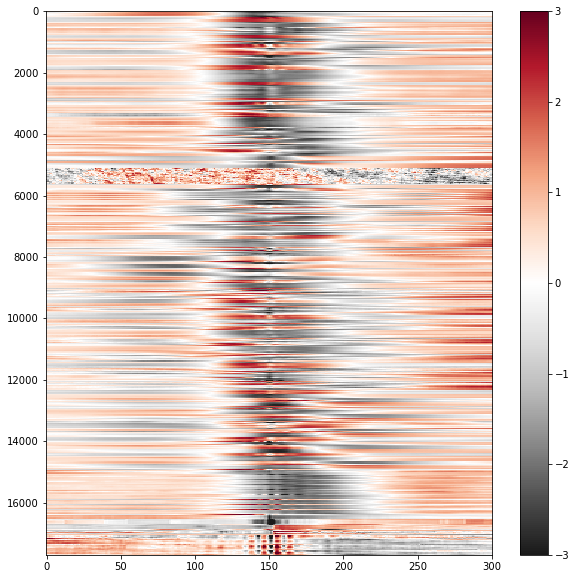

In [38]:
plt.figure(figsize=(10,10))
plt.imshow(stats.zscore(avg_rip,axis=1),aspect='auto',interpolation='nearest',vmax=3,vmin=-3,cmap='RdGy_r')
plt.colorbar()


In [77]:
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [72]:
pca = PCA()
# X = stats.zscore(avg_rip,axis=1)
X = avg_rip
pca.fit(X)
X = pca.transform(X)
X.shape

(17695, 301)

In [79]:
kmeans = KMeans(init=pca.components_, n_clusters=4)
kmeans

KMeans(init=array([[-0.05347468, -0.05351611, -0.05353121, ..., -0.05590953,
        -0.05582887, -0.05585202],
       [-0.02632651, -0.02618696, -0.02619916, ..., -0.06007369,
        -0.06054094, -0.06036083],
       [-0.05414011, -0.05457794, -0.05437565, ...,  0.03909098,
         0.03929802,  0.03871979],
       ...,
       [-0.0424308 ,  0.11006969, -0.13702485, ..., -0.01724747,
         0.01895382, -0.00736716],
       [ 0.01952589, -0.0505287 ,  0.0663798 , ..., -0.03795505,
         0.02379212, -0.00894395],
       [-0.01609669,  0.0348469 , -0.03862241, ...,  0.03970124,
        -0.0251593 ,  0.00775109]]),
       n_clusters=4)

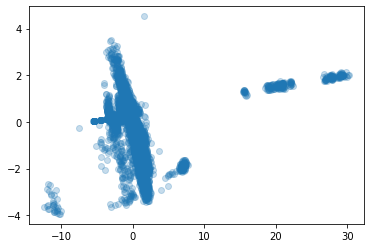

In [75]:
plt.scatter(X[:,0],X[:,1],alpha=.25)

In [80]:
pca = PCA()
# X = stats.zscore(avg_rip,axis=1)
X = avg_rip.T
pca.fit(X)
X = pca.transform(X)

In [61]:
X.shape

(301, 301)

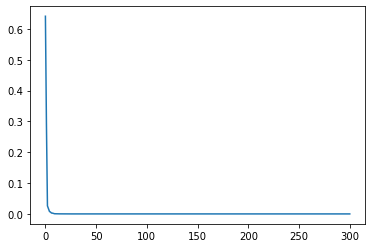

In [83]:
plt.plot(pca.explained_variance_/pca.explained_variance_.sum())

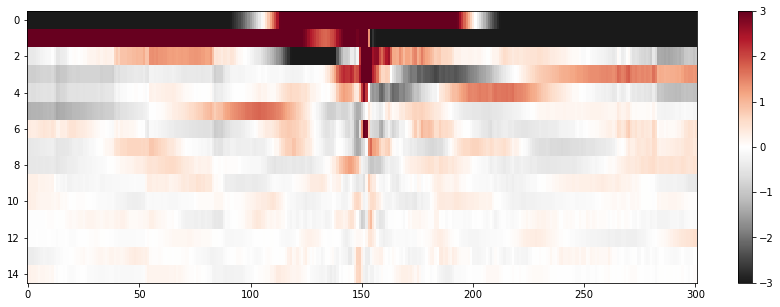

In [71]:
plt.figure(figsize=(15,5))
plt.imshow(X.T[0:15],aspect='auto',interpolation='nearest',vmax=3,vmin=-3,cmap='RdGy_r')
plt.colorbar()

In [18]:
basepath

'Z:\\Data\\GirardeauG\\Rat09\\Rat09-20140328'

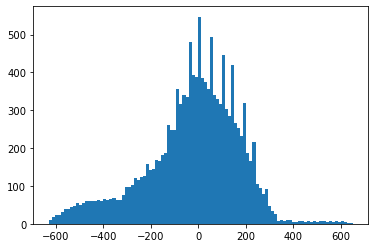

In [9]:
plt.hist(channel_df_all.channelDistance,100)
plt.show()

In [35]:
channel_df_all

'Z:\\Data\\GirardeauG\\Rat08\\Rat08-20130708'

In [ ]:
channel_df, ripple_average, ripple_time_axis = loading.load_deepSuperficialfromRipple(basepath)

In [30]:
import scipy.io as sio
import glob


basepath = r"Z:\Data\Kenji\ec014.459_480"
channel_df, ripple_average, ripple_time_axis = loading.load_deepSuperficialfromRipple(basepath)
channel_df


,channel,channelDistance,channelClass,shank,ripple_power,ripple_amplitude,SWR_diff,SWR_amplitude
0,1,0.0,Deep,0.0,0.339652,0.452168,0.477821,0.000000
1,2,-10.0,Deep,0.0,0.306845,0.039188,0.561992,0.130341
2,3,-20.0,Deep,0.0,0.596234,0.691777,0.591699,0.185541
3,4,-30.0,Deep,0.0,0.969106,-1.000000,0.679529,0.325778
4,5,-40.0,Deep,0.0,0.512357,-0.032866,0.733745,0.430672
...,...,...,...,...,...,...,...,...
91,92,50.0,Superficial,11.0,0.461468,0.048909,-0.958635,0.550648
92,93,40.0,Superficial,11.0,0.466822,0.058950,-0.907529,0.085764
93,94,30.0,Superficial,11.0,0.704850,0.659553,-0.973896,0.546790
94,95,20.0,Superficial,11.0,0.543878,0.323865,-0.948092,0.282345


In [17]:
np.hstack(ripple_average).T.shape

(96, 301)

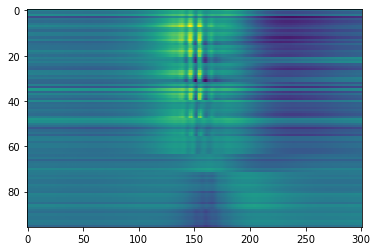

In [12]:
plt.imshow(np.hstack(ripple_average).T,aspect='auto',interpolation='nearest')

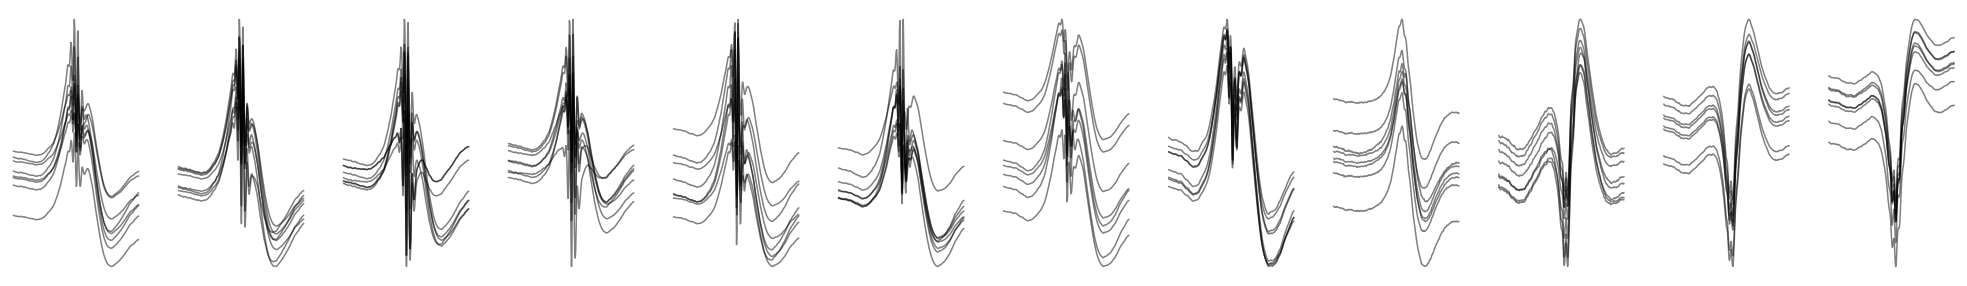

In [4]:
fig,ax = plt.subplots(1,12,figsize=(35,5))
for i,rip in enumerate(ripple_average):
    offset = channel_df[channel_df.shank == i].channelDistance.T
    ax[i].plot(ripple_time_axis,rip,alpha=.5,color='k')
    ax[i].axis('off')
    ax[i].axis('tight')
plt.show()


In [91]:
np.vstack(data['deepSuperficialfromRipple']['ripple_channels'][0][0][0]).flatten()

for shank_i,shank in enumerate(data['deepSuperficialfromRipple']['ripple_channels'][0][0][0]):
    # a,b,c = np.intersect1d(channel_df.channel,shank,return_indices=True)
    # channel_df.loc[b,'shank'] = shank_i
    a,b,c = np.intersect1d(shank,channel_df.channel,return_indices=True)
    print(shank)
    print(b)

# channel_df

[[8 7 6 5 4 3 2 1]]
[7 6 5 4 3 2 1 0]
[[16 15 14 13 12 11 10  9]]
[7 6 5 4 3 2 1 0]
[[24 23 22 21 20 19 18 17]]
[7 6 5 4 3 2 1 0]
[[32 31 30 29 28 27 26 25]]
[7 6 5 4 3 2 1 0]
[[40 39 38 37 36 35 34 33]]
[7 6 5 4 3 2 1 0]
[[48 47 46 45 44 43 42 41]]
[7 6 5 4 3 2 1 0]
[[56 55 54 53 52 51 50 49]]
[7 6 5 4 3 2 1 0]
[[64 63 62 61 60 59 58 57]]
[7 6 5 4 3 2 1 0]
[[72 71 70 69 68 67 66 65]]
[7 6 5 4 3 2 1 0]
[[80 79 78 77 76 75 74 73]]
[7 6 5 4 3 2 1 0]
[[88 87 86 85 84 83 82 81]]
[7 6 5 4 3 2 1 0]
[[96 95 94 93 92 91 90 89]]
[7 6 5 4 3 2 1 0]


In [25]:
collect = []
for item in channelClass:
    try:
        collect.append(item[0][0])
    except:
        collect.append('unknown')
len(collect)

99

In [ ]:
# channelClass[0][0][0]
channelClass = [item[0][0] for item in channelClass]
channelClass